In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp architectures

In [ ]:
#| include: false
#import sys

In [ ]:
#sys.path.append("..")

In [ ]:
#| export
import os
import numpy as np
from abc import ABC, abstractmethod

In [ ]:
#| export
from pct.functions import HPCTFUNCTION
from pct.functions import WeightedSum
from pct.functions import IndexedParameter
from pct.functions import Constant
from pct.hierarchy import PCTHierarchy
from pct.nodes import PCTNode
from pct.environments import EnvironmentFactory
from pct.structure import LevelKey
from pct.structure import ArchitectureStructure
from pct.putils import stringListToListOfStrings
from pct.errors import BaseErrorCollector

In [ ]:
#| export
class BaseArchitecture(ABC):
    "Base class of an array architecture. This class is not used direclty by developers, but defines the functionality common to all."
    def __init__(self, name=None, config=None, env=None, inputs=None, history=None, error_collector=None, namespace=None):
        self.namespace=namespace
        self.config = config      
        self.env = env
        self.inputs=inputs
        self.hpct = PCTHierarchy(history=history, error_collector=error_collector, namespace=namespace)
        self.hpct.add_preprocessor(env)
        
        for input in inputs:
            self.hpct.add_preprocessor(input)
        
    def __call__(self):
        #level0config = self.config['level0']
        previous_columns=self.configure_zerothlevel()
        
        intermediate_levels = len(self.config)-3
        level=-1
        for level in range(intermediate_levels):
            leveln = self.config[f'level{level+1}']
            levelcolumns = self.configure_level(leveln, previous_columns, level+1)
            previous_columns=levelcolumns
        if intermediate_levels < 0:
            self.set_references()          
        else:
            level+=1
            self.configure_top_level(self.config[f'level{level+1}'], level+1)
            
    def get_hierarchy(self):
        return self.hpct

    @classmethod
    def from_raw(cls, raw):
        config = {}
        config['parameters']={}
        for level in range(len(raw)):
            config[f'level{level}'] = raw[level]
        return config

 

In [ ]:
#| export
class ProportionalArchitecture(BaseArchitecture):
    "Proportional Architecture"
    def __init__(self, name="proportional", config=None, env=None, input_indexes=None, history=False, 
                 error_collector=None, namespace=None, **cargs):
        inputs=[]
        for ctr in range(len(input_indexes)):
            ip = IndexedParameter(index=input_indexes[ctr], name=f'Input{ctr}', links=[env], namespace=namespace)
            inputs.append(ip)
        
        super().__init__(name=name, config=config, env=env, inputs=inputs, history=history, error_collector=error_collector, namespace=namespace)

    def configure_zerothlevel(self):
        inputsIndex=0
        outputsIndex=1
        actionsIndex=2

        config=self.config['level0']
        level=0
        numInputs= len(self.inputs)
        columns = len(config[inputsIndex][0])
        #print(config[0][0])
        #print(columns)

        # create nodes
        for column in range(columns):
            node = PCTNode(build_links=True, mode=1, name=f'L{level}C{column}', history=self.hpct.history, 
                           namespace=self.namespace)
            # change names
            node.get_function("perception").set_name(f'PL{level}C{column}ws')
            node.get_function("reference").set_name(f'RL{level}C{column}ws')
            node.get_function("comparator").set_name(f'CL{level}C{column}')
            node.get_function("output").set_name(f'OL{level}C{column}p')

            weights=[]
            # configure perceptions
            for inputIndex in range(numInputs):
                node.get_function("perception").add_link(self.inputs[inputIndex])
                weights.append(config[inputsIndex][inputIndex][column])
            node.get_function("perception").weights=weights #np.array(weights)

            # configure outputs
            node.get_function("output").set_property('gain', config[outputsIndex][column])

            self.hpct.add_node(node, level, column)

        # configure actions
        numActions = len(config[actionsIndex])
        numColumnsThisLevel = len(config[outputsIndex])
        for actionIndex in range(numActions):
            action = WeightedSum(weights=config[actionsIndex][actionIndex], name=f'Action{actionIndex+1}ws', namespace=self.namespace)
            for column in range(numColumnsThisLevel):
                action.add_link(f'OL{level}C{column}p')
            self.hpct.add_postprocessor(action)
            self.env.add_link(action)

        return numColumnsThisLevel

    def configure_level(self, config, numColumnsPreviousLevel, level):
        inputsIndex=0
        outputsIndex=1
        referencesIndex=2
        
        #numColumnsPreviousLevel=len(config[referencesIndex])
        numColumnsThisLevel = len(config[outputsIndex])
    
        # create nodes
        for column in range(numColumnsThisLevel):
            node = PCTNode(build_links=True, mode=1, name=f'L{level}C{column}', history=self.hpct.history, namespace=self.namespace)
            # change names
            node.get_function("perception").set_name(f'PL{level}C{column}ws')
            node.get_function("reference").set_name(f'RL{level}C{column}ws')
            node.get_function("comparator").set_name(f'CL{level}C{column}')
            node.get_function("output").set_name(f'OL{level}C{column}p')
            
            weights=[]
            # configure perceptions        
            for inputIndex in range(numColumnsPreviousLevel):
                node.get_function("perception").add_link(f'PL{level-1}C{inputIndex}ws')
                weights.append(config[inputsIndex][column][inputIndex])           
    
            node.get_function("perception").weights=weights #np.array(weights)
            
            # configure outputs
            node.get_function("output").set_property('gain', config[outputsIndex][column])        
                
            self.hpct.add_node(node, level, column)
    
        # configure lower references
        for referenceIndex in range(numColumnsPreviousLevel):
            reference = self.hpct.get_function(level-1, referenceIndex, "reference")
            weights=[]
            
            for output_column in range(numColumnsThisLevel):
                reference.add_link(f'OL{level}C{output_column}p')
                weights.append(config[referencesIndex][referenceIndex][output_column])           
                
            reference.weights=weights #np.array(weights)
    
        return numColumnsThisLevel

    def configure_top_level(self, config, level):
        inputsIndex=0
        outputsIndex=1
        lowerReferencesIndex=2
        topReferencesIndex=3
    
        numColumnsThisLevel = len(config[topReferencesIndex])
        numColumnsPreviousLevel=len(config[lowerReferencesIndex])
        
        # create nodes
        for column in range(numColumnsThisLevel):
            node = PCTNode(build_links=True, mode=2, name=f'L{level}C{column}', history=self.hpct.history, namespace=self.namespace)
            # change names
            reference = Constant(config[topReferencesIndex][column], name=f'RL{level}C{column}c', namespace=self.namespace)
            node.replace_function("reference", reference, 0)
            node.get_function("perception").set_name(f'PL{level}C{column}ws')
            #node.get_function("reference").set_name(f'RL{level}C{column}ws')
            node.get_function("comparator").set_name(f'CL{level}C{column}')
            node.get_function("output").set_name(f'OL{level}C{column}p')
            node.get_function("comparator").set_link(reference)
            node.get_function("comparator").add_link(node.get_function("perception"))
            
            # set reference value
            #node.get_function("reference").set_property('value', config[topReferencesIndex][column])
            
            
            weights=[]
            # configure perceptions        
            for inputIndex in range(numColumnsPreviousLevel):
                node.get_function("perception").add_link(f'PL{level-1}C{inputIndex}ws')
                weights.append(config[inputsIndex][column][inputIndex])           
                #weights.append(config[inputsIndex][inputIndex][column])           
            node.get_function("perception").weights=weights #np.array(weights)
            
            # configure outputs
            node.get_function("output").set_property('gain', config[outputsIndex][column])        
                
            self.hpct.add_node(node, level, column)
    
        # configure lower references
        for referenceIndex in range(numColumnsPreviousLevel):
            reference = self.hpct.get_function(level-1, referenceIndex, "reference")
            weights=[]
            
            for output_column in range(numColumnsThisLevel):
                reference.add_link(f'OL{level}C{output_column}p')
                weights.append(config[lowerReferencesIndex][referenceIndex][output_column])           
                
            reference.weights=weights #np.array(weights)


    def set_references(self):
        level=0
        config=self.config['level0']
        topReferencesIndex=3
    
        numColumnsThisLevel = len(config[topReferencesIndex])
        # change nodes
        for column in range(numColumnsThisLevel):
            node = self.hpct.get_node(level, column)
            reference = Constant(config[topReferencesIndex][column], name=f'RL{level}C{column}c', namespace=self.namespace)
            node.replace_function("reference", reference, 0)
            node.get_function("comparator").set_link(reference)
            node.get_function("comparator").add_link(node.get_function("perception"))


 

In [ ]:
#| export
class DynamicArchitecture(BaseArchitecture):
    "Dynamic Architecture"
    def __init__(self, name="dynamic", structure=None, config=None, env=None, input_indexes=None, inputs_names=None,
                 top_input_indexes=None, history=False, error_collector=None, suffixes = False, namespace=None, **cargs):


        inputs=[]
        if top_input_indexes != None:
            self.top_inputs = []
            self.zero_inputs = []
        else:
            self.top_inputs = None
            self.zero_inputs = None

        for ctr in range(len(input_indexes)):            
            if inputs_names == None:
                input_name=f'Input{ctr}'
            else:
                input_name = inputs_names[ctr]
            
            ip = IndexedParameter(index=input_indexes[ctr], name=input_name, links=[env], namespace=namespace)
            inputs.append(ip)
            if top_input_indexes != None :
                if input_indexes[ctr] in top_input_indexes :
                    self.top_inputs.append(ip)
                else:
                    self.zero_inputs.append(ip)
                
        super().__init__(name, config, env, inputs, history, error_collector, namespace=namespace)
        self.suffixes=suffixes
        self.structure=structure

    def __call__(self):
        #level0config = self.config['level0']
        levels = len(self.config)-1
        #print('levels', levels)
        if levels == 1:
            self.configure_zerotoplevel()
        else:           
            previous_columns=self.configure_zerothlevel()
            
            intermediate_levels = len(self.config)-3
            level=-1
            for level in range(intermediate_levels):
                leveln = self.config[f'level{level+1}']
                levelcolumns = self.configure_level(leveln, previous_columns, level+1)
                previous_columns=levelcolumns
            if intermediate_levels < 0:
                self.set_references()          
            else:
                level+=1
                self.configure_top_level(self.config[f'level{level+1}'], level+1, previous_columns)
        if self.suffixes:
            self.hpct.set_suffixes()


    def configure_zerotoplevel(self):
        #print(self.structure.get_parameter('modes'))
        mode = self.structure.get_parameter('modes')[LevelKey.ZEROTOP]

        inputsIndex=0
        outputsIndex=1
        referencesIndex=2
        actionsIndex=3

        config=self.config['level0']
        level=0
        #numInputs= len(self.inputs)
        columns = len(config[inputsIndex][0])
        #print(config[0][0])
        #print('columns',columns)

        # create nodes
        for column in range(columns):
            node = PCTNode(build_links=True, mode=mode, name=f'L{level}C{column}', history=self.hpct.history, namespace=self.namespace)
            self.structure.set_node_function(node, HPCTFUNCTION.REFERENCE, mode , level, None, None,  column, None, None, config[referencesIndex], True, 0)            
            self.structure.set_node_function(node, HPCTFUNCTION.PERCEPTION, mode, level, None, None,  column, len(self.inputs), self.inputs, config[inputsIndex], False,0)

            comparator_name=f'CL{level}C{column}'
            node.get_function("comparator").set_name(comparator_name)
            node.get_function("comparator").set_link(node.get_function("reference"))
            node.get_function("comparator").add_link(node.get_function("perception"))

            self.structure.set_output_function(node, mode, level, column, config[outputsIndex])

            self.hpct.add_node(node, level, column)

        # configure actions
        numColumnsThisLevel = len(config[outputsIndex])
        self.structure.set_action_function(self.hpct, self.env, numColumnsThisLevel, config[actionsIndex])
        
        return numColumnsThisLevel
            
    def configure_zerothlevel(self):
        mode = self.structure.get_parameter('modes')[LevelKey.ZERO]

        inputsIndex=0
        outputsIndex=1
        referencesIndex=2
        actionsIndex=3

        config=self.config['level0']
        level=0
        columns = len(config[inputsIndex][0])
        #print(config[0][0])
        #print(columns)
        columnsNextLevel = len(config[referencesIndex][0])
        #print('columnsNextLevel',columnsNextLevel)
        
        if self.top_inputs == None:                    
            num_inputs = len(self.inputs)
            inputs = self.inputs
        else:
            num_inputs = len(self.zero_inputs)
            inputs = self.zero_inputs

            
        # create nodes
        for column in range(columns):
            node = PCTNode(build_links=True, mode=mode, name=f'L{level}C{column}', history=self.hpct.history, namespace=self.namespace)
            self.structure.set_node_function(node, HPCTFUNCTION.REFERENCE, mode, level, level+1, 'O', 
                                             column, columnsNextLevel, None, config[referencesIndex], True, 0)
            self.structure.set_node_function(node, HPCTFUNCTION.PERCEPTION, mode, level, None, None, 
                                             column, num_inputs, inputs, config[inputsIndex], False, 0)

            comparator_name=f'CL{level}C{column}'
            node.get_function("comparator").set_name(comparator_name)

            self.structure.set_output_function(node, mode, level, column, config[outputsIndex])

            self.hpct.add_node(node, level, column)

        # configure actions
        numColumnsThisLevel = len(config[outputsIndex])
        self.structure.set_action_function(self.hpct, self.env, numColumnsThisLevel, config[actionsIndex])

        return numColumnsThisLevel

    def configure_level(self, config, numColumnsPreviousLevel, level):
        mode = self.structure.get_parameter('modes')[LevelKey.N]

        inputsIndex=0
        outputsIndex=1
        referencesIndex=2

        #numColumnsPreviousLevel=len(config[referencesIndex])
        numColumnsThisLevel = len(config[outputsIndex])
        columnsNextLevel = len(config[referencesIndex][0])
                

        # create nodes
        for column in range(numColumnsThisLevel):
            node = PCTNode(build_links=True, mode=mode, name=f'L{level}C{column}', history=self.hpct.history, namespace=self.namespace)
            self.structure.set_node_function(node, HPCTFUNCTION.REFERENCE, mode, level, level+1, 'O', 
                                             column, columnsNextLevel, None, config[referencesIndex], True, 0)
            self.structure.set_node_function(node, HPCTFUNCTION.PERCEPTION, mode, level, level-1, 'P', 
                                             column, numColumnsPreviousLevel, None, config[inputsIndex], False, 0)

            comparator_name=f'CL{level}C{column}'
            node.get_function("comparator").set_name(comparator_name)

            self.structure.set_output_function(node, mode, level, column, config[outputsIndex])

            self.hpct.add_node(node, level, column)

        return numColumnsThisLevel

    def configure_top_level(self, config, level, numColumnsPreviousLevel ):
        mode = self.structure.get_parameter('modes')[LevelKey.TOP]
        inputsIndex=0
        outputsIndex=1
        referencesIndex=2

        numColumnsThisLevel = len(config[referencesIndex])
        offset=0

        # create nodes
        for column in range(numColumnsThisLevel):
            node = PCTNode(build_links=True, mode=mode, name=f'L{level}C{column}', history=self.hpct.history, namespace=self.namespace)
            
            self.structure.set_node_function(node, HPCTFUNCTION.REFERENCE, mode, level, None, None, 
                                             column, None, None, config[referencesIndex], None, 0)
            
            
            if self.top_inputs != None and column < len(self.top_inputs):  
                offset = len(self.top_inputs)          
                self.structure.set_sparse_node_function(node, HPCTFUNCTION.PERCEPTION, level, 
                        self.top_inputs[column], column, config[inputsIndex])
            else:
                self.structure.set_node_function(node, HPCTFUNCTION.PERCEPTION, mode, level, level-1, 'P', 
                                             column, numColumnsPreviousLevel, None, config[inputsIndex], False, offset)

            comparator_name=f'CL{level}C{column}'
            node.get_function("comparator").set_name(comparator_name)
            node.get_function("comparator").set_link(node.get_function('reference'))
            node.get_function("comparator").add_link(node.get_function('perception'))
            
            self.structure.set_output_function(node, mode, level, column, config[outputsIndex])

            self.hpct.add_node(node, level, column)

            
    @classmethod
    def draw_raw(cls, raw, arch_structure=None, env=None, inputs=None, inputs_names=None, move={}, 
                 top_input_indexes=None, figsize=(12,12), layout=None, summary=False):
        if inputs==None:
            num_inputs = len(raw[0][0])
            inputs = [i for i in range(num_inputs)]
            
        if env == None:
            env = EnvironmentFactory.createEnvironment('DummyModel', seed=1)
        env.reset(seed=1)
        namespace=env.namespace
        
        if arch_structure==None:
            arch_structure = ArchitectureStructure(namespace=namespace)
                    
        config = BaseArchitecture.from_raw( raw)
        #print(config)
        pa = DynamicArchitecture(structure=arch_structure, config=config, env=env, input_indexes=inputs, 
                                 inputs_names=inputs_names, top_input_indexes=top_input_indexes, suffixes=True, namespace=namespace) 
        pa()
        hpct = pa.get_hierarchy()
        if summary:
            hpct.summary()
        #if inputs_names != None:
        #    for ctr in range(len(inputs_names)):
        #        hpct.get_preprocessor()[ctr+1].set_name(inputs_names[ctr])
        if layout==None:
            hpct.draw(move=move, figsize=figsize, with_edge_labels=True)
        else:        
            hpct.draw(move=move, figsize=figsize, with_edge_labels=True, layout=layout)

            
    @classmethod        
    def run_raw(cls, raw=None, arch_structure=None, env=None, runs=None, inputs=None, inputs_names=None, 
                top_input_indexes=None, history=False, move={}, figsize=(12,12), layout=None, summary=False, 
                draw=False, seed=None, verbose=False, error_collector_type ='TotalError', 
                error_response_type ='RootSumSquaredError', error_properties=None, error_limit =None, suffixes=False):
        
        if inputs==None:
            num_inputs = len(raw[0][0])
            inputs = [i for i in range(num_inputs)]       
            
                        
        if env == None:
            env = EnvironmentFactory.createEnvironment('DummyModel')
        env.reset(seed=1)
        namespace=env.namespace
        if arch_structure==None:
            arch_structure = ArchitectureStructure(namespace=namespace)

        config = BaseArchitecture.from_raw( raw)

        error_collector = BaseErrorCollector.collector(error_response_type, error_collector_type
                                                       , error_limit, properties=error_properties)
        if seed != None:
            env.set_seed(seed)
        env.reset(seed=1)

        da = DynamicArchitecture(structure=arch_structure, config=config, env=env, input_indexes=inputs, 
                                 inputs_names=inputs_names, top_input_indexes=top_input_indexes, 
                                 history=history, error_collector=error_collector, suffixes=suffixes,         
                                 namespace=namespace) 
        da()
        hpct = da.get_hierarchy()
        #if inputs_names != None:
        #    for ctr in range(len(inputs_names)):
        #        hpct.get_preprocessor()[ctr+1].set_name(inputs_names[ctr])

        if summary:
            hpct.summary()

        status = hpct.run(steps=runs, verbose=verbose)
        last_step = hpct.last_step()
        if last_step < runs-1:
            print('Terminated early')

        if draw:
            if layout==None:
                hpct.draw(move=move, figsize=figsize, with_edge_labels=True)
            else:        
                hpct.draw(move=move, figsize=figsize, with_edge_labels=True, layout=layout)

        score = hpct.get_error_collector().error()

        return score, last_step, hpct        

In [ ]:
#| export
def run_from_properties_file(root_dir='.', path='.', file=None, nevals=None, runs=500, history=True, verbose=False, 
        test=False, move=None,  draw=False, plots_figsize=(15,4), render=True,  layout=None, early_termination=False,
        plots=None, seed=None, print_properties=False, figsize=(12,12), summary=False, hpct_verbose=False,
        error_collector_type=None, error_response_type=None, draw_file=None, funcdata=False):

        
    properties = load_properties(root_dir, path, file, print_properties=print_properties)    
    if seed == None:
        seed = properties['seed']
    if nevals == None:
        nevals = properties['nevals']

    score_sum = 0

    for seedn in range(seed, nevals+seed, 1):
        if verbose:
            print(f'seed {seedn}', end = ' ')
        try:
            env, error_collector = setup_environment(properties, render=render, seed=seedn, 
                early_termination=early_termination, error_collector_type=error_collector_type, 
                error_response_type=error_response_type)
            hpct = create_hierarchy(env, error_collector, properties, history=True, suffixes=True)
            if summary:
                hpct.summary()

            output = hpct.run(steps=runs, verbose=hpct_verbose)
            last_step = hpct.last_step()
            if last_step < runs-1:
                if verbose:
                    print('<TE>', end=' ')

            env.close()
            if draw:
                if layout==None:
                    hpct.draw(move=move, figsize=figsize, with_edge_labels=True, file=draw_file, funcdata=funcdata)
                else:        
                    hpct.draw(move=move, figsize=figsize, with_edge_labels=True, layout=layout, file=draw_file, funcdata=funcdata)

            score = hpct.get_error_collector().error()
            score_sum += score
            if verbose:
                print(f'score {score:5.3f} last step {last_step}')
            for plot_item in plots:
                fig = hpct.hierarchy_plots(title=plot_item['title'], plot_items=plot_item['plot_items'], figsize=plots_figsize)
            draw = False
        except KeyError as ex:
                print()
                print('KeyError: ',ex.__str__())
                break

    
    return hpct, score_sum, output

In [ ]:
#| export
def load_properties(root_dir=None, file_path=None, file_name=None, nevals=None, seed=None, print_properties=False, 
                    gens=None, pop_size=None, evolve=False):
    from jproperties import Properties
    delim = os.sep
    file = delim.join((root_dir, file_path, file_name))
    
    # read properties from file
    configs = Properties()
    with open(file, 'rb') as config_file:
        configs.load(config_file)
    items_view = configs.items()
    db = {}     
    for item in items_view:
        db[item[0]] = item[1].data     

    # evolve arguments
    if pop_size == None:
        pop_size = int(db['POPULATION_SIZE'])
    if gens==None:
        gens = int(db['MAX_GENERATIONS'])
        
    if evolve:
        raw = None
    else:
        if 'raw' in db.keys(): 
            raw = eval(db['raw'])    
        else:
            fh = open(file, "r")
            for _ in range(5):
                line = fh.readline()
                #print('<',line,'>')
                if line.startswith('# Best individual'):
                    break
            line = fh.readline()
            #print(line[2:])
            raw = eval(line[2:])    
            fh.close()
    
    early_termination=None
    if 'early_termination' in db.keys():
        early_termination=eval(db['early_termination'])

    inputs = eval(db['inputs'])
    references = eval(db['references']) 
    top_inputs=None
    if 'top_inputs' in db.keys():
        top_inputs=eval(db['top_inputs'])

    error_collector_type = 'TotalError'
    if 'error_collector' in db.keys():
        error_collector_type = db['error_collector']
    error_response_type = 'RootSumSquaredError'
    if 'error_response' in db.keys():
        error_response_type = db['error_response']
    inputs_names = stringListToListOfStrings(db['inputs_names'], ',')
    
    error_properties = []
    for property in range(1, 100):
        property_key = f'property{property}'
        if property_key in db.keys():
            property_string = db[property_key]
            strarr = property_string.split(':')
            if strarr[0] == 'error':
                parr = strarr[1].split(',')
                prop=[]
                prop.append(parr[0])
                prop.append(parr[1])
                error_properties.append(prop)    

    min_levels_limit = 1
    if 'min_levels_limit' in db.keys():
         min_levels_limit = int(db['min_levels_limit'])

    min_columns_limit = 1
    if 'min_columns_limit' in db.keys():
         min_columns_limit = int(db['min_columns_limit'])

    # extract config
    modes_list = eval(db['modes'])
                
    types_strings={}
    for type in range(1, 100):
        type_key = f'type{type}'
        if type_key in db.keys():
            types_strings[type_key]=db[type_key]

    configs_strings={}
    for config in range(1, 100):
        config_key = f'config{config}'
        if config_key in db.keys():
            configs_strings[config_key]=db[config_key]

            
    if nevals == None: 
        if 'nevals' in db.keys(): 
            nevals  = int(db['nevals'])
        else:
            nevals = 1
        
    if seed==None:        
        if 'seed' in db.keys():
            seed = int(db['seed'])
        
    modes = eval(db['modes'])
    
    
    if print_properties:
        print('Properties:')
        print('Description = ', db['desc'])
        print('inputs = ', inputs)
        print('references = ', references)
        print('top_inputs = ', top_inputs)
        print('names = ', inputs_names)        
        if early_termination!=None:
            print('early_termination = ', early_termination)
        print('error_collector = ', error_collector_type)
        print('error_response = ',error_response_type)
        print('seed = ',seed)
        print('nevals = ',nevals)
        print('modes = ',modes)
        if raw != None:
            print(raw)        

    properties = {'raw':raw, 'modes':modes, 'env_name': db['env'], 'inputs': inputs, 'top_inputs':top_inputs, 
                  'error_collector_type':error_collector_type, 'error_response_type': error_response_type, 
                  'seed':seed, 'nevals':nevals, 'error_limit':eval(db['error_limit']), 'desc':db['desc'],
                  'error_properties':error_properties, 'inputs_names':inputs_names, 'attr_mut_pb':float(db['attr_mut_pb']), 
                  'structurepb':float(db['structurepb']), 'runs':db['runs'], 'p_crossover': db['p_crossover'], 
                  'p_mutation': db['p_mutation'], 'num_actions':int(db['num_actions']), 'early_termination':early_termination,
                  'lower_float':float(db['lower_float']), 'upper_float':float( db['upper_float']), 
                  'levels_limit': int(db['levels_limit']), 'columns_limit': int(db['columns_limit']), 
                  'min_levels_limit': min_levels_limit, 'min_columns_limit': min_columns_limit, 'types_strings':types_strings,
                  'configs_strings': configs_strings, 'references':references, 'gens':gens, 'pop_size':pop_size
                 }

    return properties 

In [ ]:
#| export
def setup_environment(properties, render=False, seed=None, early_termination=None, 
        error_collector_type=None, error_response_type=None):    
    
    if error_collector_type == None:
        error_collector_type = properties['error_collector_type']
    if error_response_type == None:
        error_response_type = properties['error_response_type']
    if early_termination == None:
        early_termination = properties['early_termination']
        
    env_name = properties['env_name']
    error_limit = properties['error_limit']
    error_properties = properties['error_properties']
    if seed == None:
        seed = properties['seed']


    env = EnvironmentFactory.createEnvironment(env_name, seed=seed)
    env.render=render
    env.set_name(env_name)
    env.early_termination = early_termination
                    
    if env == None:
        env = EnvironmentFactory.createEnvironment('DummyModel', seed=1)

    error_collector = BaseErrorCollector.collector(error_response_type, error_collector_type, error_limit, properties=error_properties)
    #if seed != None:
    #    env.set_seed(seed)
    s=1 if seed==None else seed
    env.reset(seed=s)

    return env, error_collector

In [ ]:
#| export
def create_hierarchy(env, error_collector, properties, history=False, suffixes=False):
    inputs = properties['inputs']
    raw = properties['raw']
    inputs_names = properties['inputs_names']
    top_input_indexes = properties['top_inputs']
    modes = properties['modes']

    if inputs==None:
        num_inputs = len(raw[0][0])
        inputs = [i for i in range(num_inputs)]       

    config = BaseArchitecture.from_raw( raw)
                
    namespace=env.namespace
    modes =  {LevelKey.ZERO:modes[0], LevelKey.N:modes[1],LevelKey.TOP:modes[2],LevelKey.ZEROTOP :modes[3]}
    arch_structure = ArchitectureStructure(modes=modes,     namespace=namespace)

    da = DynamicArchitecture(structure=arch_structure, config=config, env=env, input_indexes=inputs, 
                             inputs_names=inputs_names, top_input_indexes=top_input_indexes, history=history, 
                             error_collector=error_collector, suffixes=suffixes, namespace=namespace) 
    da()
    hpct = da.get_hierarchy()
    
    return hpct

In [ ]:
from pct.environments import VelocityModel
from pct.structure import ArchitectureStructure
from pct.functions import IndexedParameter
from pct.hierarchy import PCTHierarchy
from pct.structure import LevelKey
from pct.nodes import PCTNode

In [ ]:
env = VelocityModel(name='VModel')
namespace=env.namespace
inputs=[2]
structure = ArchitectureStructure()
config = {'parameters': {}, 'level0': [[[1.0864011617580416, -1.0342161642584196], [-8.899524671308557, -8.976856229389936]], [-0.7295091920311653, -4.460573287694404], [0, 0], [[-4.146713118740296, 1.2794655139677662]]]}
pa = DynamicArchitecture(structure=structure, config=config, env=env, input_indexes=inputs, namespace=namespace) #, error_collector=te)

pa()
#hpct = pa.get_hierarchy()
#hpct.summary()
#move={'VModel': [-0.2, -0.3],'Input0': [-0.3, 0],'OL0C0ws': [-0.4, 0],'OL0C1ws': [0.6, 0]}
#hpct.draw(move=move, with_edge_labels=True, figsize=(14,14))

In [ ]:
from pct.environments import Pendulum
from pct.functions import Constant

level0 [[[0, 0, 1], [0, 0, 1]], [74.7727669099358, 37.42447782017047, 70.45900090605967], [[1, 0, 1]]]
level1 [[[1, 0, 1], [1, 1, 1]], [0.028281504070566288, 0.29618653732851286], [[-49.05302284318027, 46.949638698585005], [-96.63198831250754, -29.78373183094591], [-3.8249493797145107, -60.95121501461629]]]
level2 [[[1, 0], [0, 1]], [0.633350421196448, 0.5607290603484817], [[41.217164164869104, -76.70635343790484], [83.21744682425535, -96.9311066757899]], [1, 2]]
parameters {}


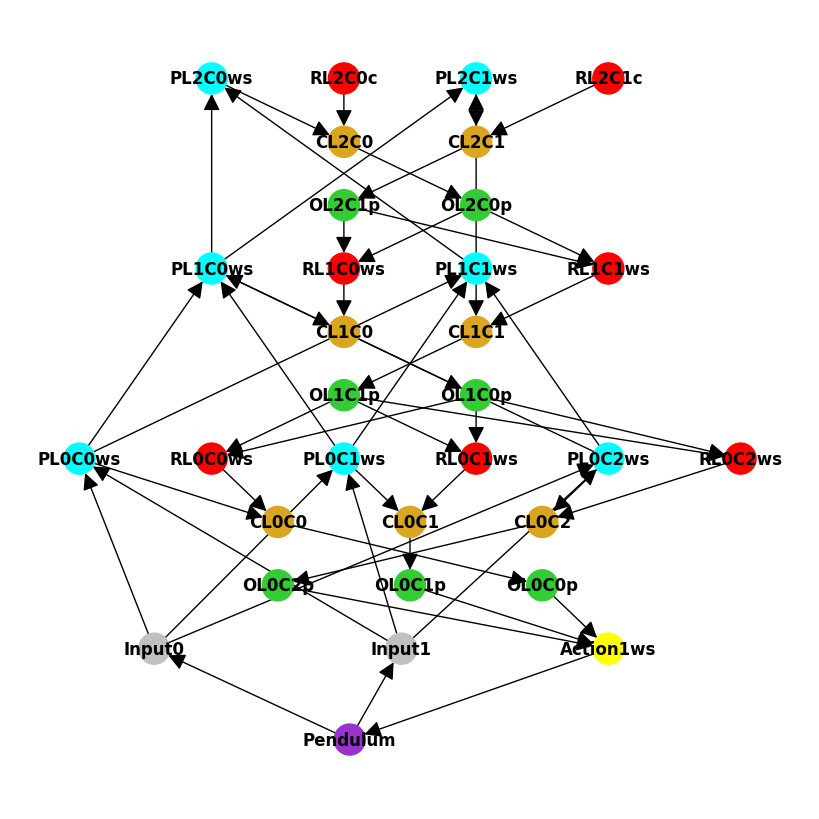

In [ ]:
pen = Pendulum(name='Pendulum',render=True, seed=1)
namespace = pen.namespace
#print(namespace)
inputs=[2, 3]
config = {'level0': [[[0, 0, 1], [0, 0, 1]], [74.7727669099358, 37.42447782017047, 70.45900090605967], [[1, 0, 1]]], 'level1': [[[1, 0, 1], [1, 1, 1]], [0.028281504070566288, 0.29618653732851286], [[-49.05302284318027, 46.949638698585005], [-96.63198831250754, -29.78373183094591], [-3.8249493797145107, -60.95121501461629]]], 'level2': [[[1, 0], [0, 1]], [0.633350421196448, 0.5607290603484817], [[41.217164164869104, -76.70635343790484], [83.21744682425535, -96.9311066757899]], [1, 2]], 'parameters': {}}
for key in config.keys():
    print(key, config[key])
pa = ProportionalArchitecture(config=config, env=pen, input_indexes=inputs, namespace=namespace)
pa()
hpct = pa.get_hierarchy()
hpct.draw(move={'Pendulum': [-0.2, -0.3],'Input0': [-0.3, 0], 'Input1': [0.3, 0]})

level0 [[[0], [0]], [60.92750637861888], [[1]]]
level1 [[[1], [1]], [0.8221926728404025, 0.5936199577845901], [[2.941087338758976, -68.59700733589955]], [1, 2]]
parameters {}


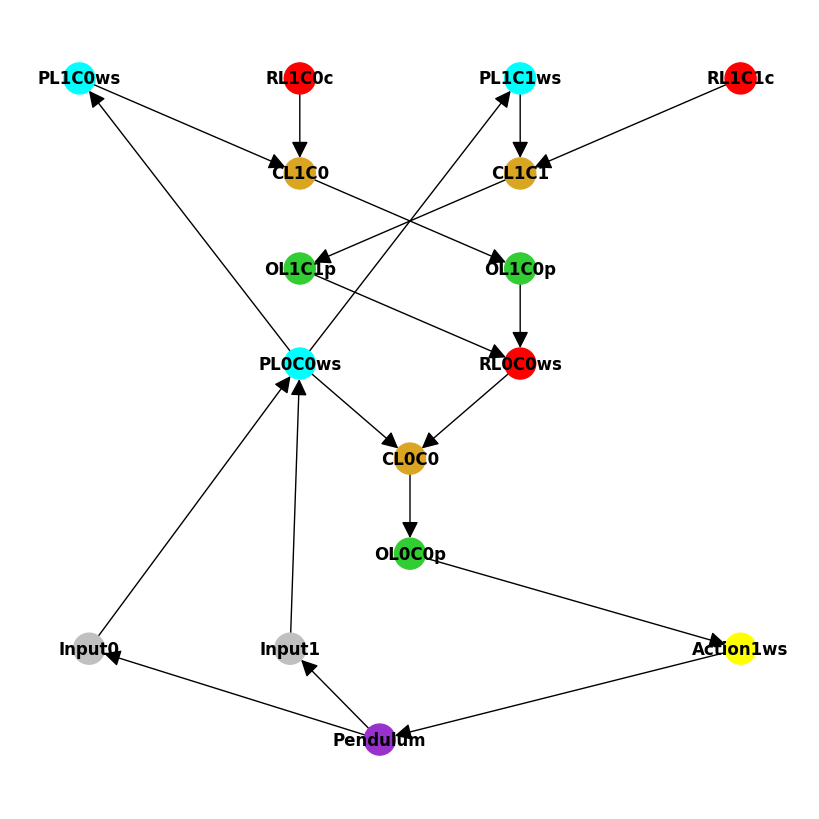

In [ ]:
pen = Pendulum(name='Pendulum',render=True, seed=1)
namespace = pen.namespace
inputs=[2, 3]
config = {'level0': [[[0], [0]], [60.92750637861888], [[1]]], 'level1': [[[1], [1]], [0.8221926728404025, 0.5936199577845901], [[2.941087338758976, -68.59700733589955]], [1, 2]], 'parameters': {}}
for key in config.keys():
    print(key, config[key])
pa = ProportionalArchitecture(config=config, env=pen, input_indexes=inputs, namespace = namespace)
pa()
hpct = pa.get_hierarchy()
hpct.draw(move={'Pendulum': [-0.2, -0.3],'Input0': [-0.3, 0], 'Input1': [0.3, 0]})

level0 [[[1]], [62.82423385532463], [[0]], [1]]
parameters {}


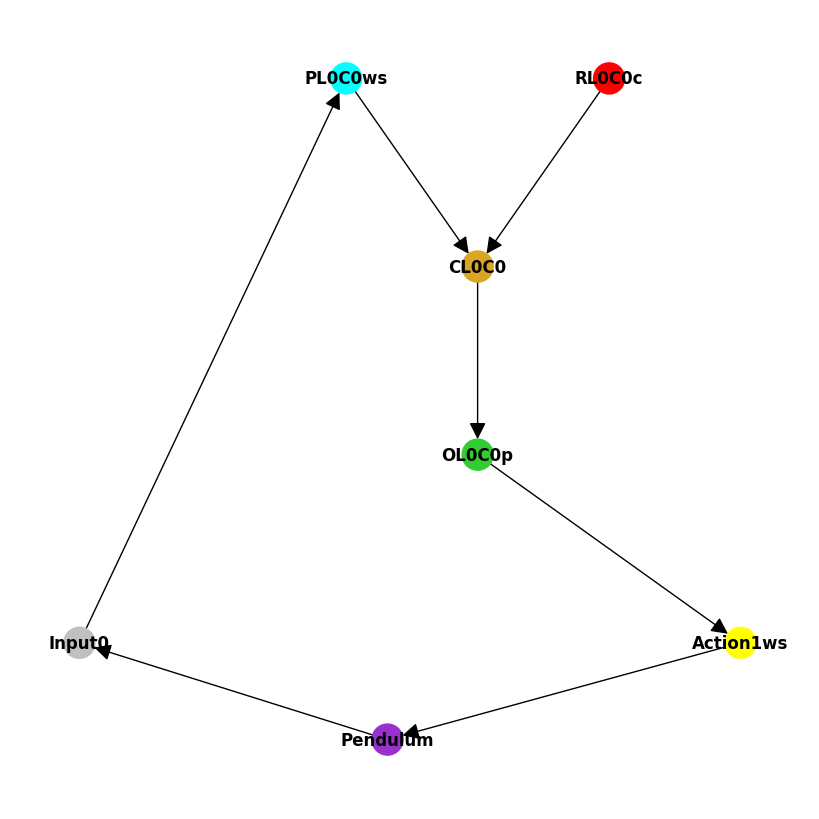

In [ ]:
pen = Pendulum(name='Pendulum',render=True, seed=1)
namespace = pen.namespace
inputs=[2]
config = {'level0': [[[1]], [62.82423385532463], [[0]], [1]], 'parameters': {}}
for key in config.keys():
    print(key, config[key])
    
pa = ProportionalArchitecture(config=config, env=pen, input_indexes=inputs, namespace = namespace)
pa()
hpct = pa.get_hierarchy()
hpct.draw(move={'Pendulum': [-0.2, -0.3],'Input0': [-0.3, 0]})

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()